## Task 4

Датасет русскоязычных отзывов на аниме. 3 класса: нейтральный, положительный и отрицательный.

1) Требуется качественная обработка данных + feature engineering.

2) Сравнить случайный лес и бустинг для сентимент анализа.

3) Отобразить ключевые слова для решения классификаторов.

4) Отрисовать рисунки обученных деревьев из случайного леса и бустинга с указанием текста, влияющего на ветвление дерева.

5) Использовать SHAP для интерпретации.

6) Провести тематическое моделирование отдельно для 3 классов и сравнить с пунктами 3-5.

7) Выложить на github.


## Imports

In [278]:
!pip install emoji --upgrade

In [ ]:
!pip install pymorphy3

In [927]:
import pandas as pd
import numpy as np
import re

from nltk import word_tokenize, sent_tokenize, download
from nltk.corpus import stopwords
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns
import emoji
from collections import Counter
from tqdm import tqdm
import unicodedata
import html
from nltk import pos_tag

download('punkt')
download('stopwords')
stop_words = stopwords.words('russian')

import pymorphy3
morph = pymorphy3.MorphAnalyzer()
from sklearn.preprocessing import LabelEncoder
from gensim.models import KeyedVectors
from sklearn.model_selection import train_test_split
import gensim

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/olgapetrukhina/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/olgapetrukhina/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Анализ датасета

**Объединяю все датасеты в один**

In [1398]:
df1 = pd.read_excel('dataset1.xlsx')
df2 = pd.read_excel('dataset2.xlsx')
df3 = pd.read_excel('dataset3.xlsx')
df4 = pd.read_excel('dataset4.xlsx')

In [1399]:
df = pd.concat([df1, df2, df3, df4], ignore_index=True)

In [1400]:
df

,Anime,Rate,Text
0,Нежный укус / Amagami SS,Нейтральный,"после первой арки несколько разочаровался, ожи..."
1,Легенда о легендарных героях / Densetsu no Yuu...,Положительный,"Концовка какая-то мутная, ничего не понял. Над..."
2,Мобильный воин Гандам: Единорог / Kidou Senshi...,Положительный,"Что тут сказать? Никакого сравнени я с Seed, х..."
3,Невиданный цветок / Ano Hi Mita Hana no Namae ...,Положительный,Только что досмотрел и меня переполняют эмоции...
4,Принцесса-медуза / Kuragehime,Положительный,"И правда не оторваться. Но, по-моему, то, что ..."
...,...,...,...
73211,Пожиратель звёзд / Tunshi Xingkong,Положительный,Я просмотрел 82 серии Пожирателя звёзд (Swallo...
73212,Пожиратель звёзд 2 / Tunshi Xingkong 2nd Season,Положительный,Я был сильно заинтригован аниме Поглощающая Зв...
73213,Повелитель 2 / Overlord II,Нейтральный,докатились. после просмотра этого чуда я добав...
73214,Ангел по соседству / Otonari no Tenshi-sama ni...,Положительный,Вокруг этого произведения собралось достаточно...


**Удаляю повторы и пустые строки**

In [1401]:
len(df)

73216

In [1402]:
df = df.drop_duplicates(subset=['Text'])

In [1403]:
len(df)

73166

In [1410]:
missing_values = df.isnull().sum()
missing_values

Anime    0
Rate     0
Text     1
dtype: int64

In [1412]:
df = df.dropna(subset=["Text"])

**Я заметила, что одни и те же слова, специфичные для этого датасета, могут писаться по-разному, например, 'фентези' вместо 'фэнтези' и т.д. Составляю словарик, чтобы после лемматизации привести слова к одной форме**

In [1414]:
variations = {
    'фэнтези': ['фентези'],
    'хентай': ['хэнтай'],
    'аниме': ['анимэ', 'анеме', 'анемэ', 'ониме', 'онимэ'],
    'новелла': ['новэлла', 'новела'],
    'сёнен': ['шёнен', 'сёнэн'],
    'исэкай': ['исекай'],
    'трэш': ['треш'],
    'саске': ['саскэ'],
    'кагоме': ['кагомэ'],
    'супергерой': ['супер герой'],
    'семпай': ['сэмпай'],
    'кун': ['kun'],
    'чиби': ['чибби'],
    'ня': ['мя'],
    'гарем': ['гаремник', 'harem'],
    'сёдзё': ['сёдзе'],
    'ничего': ['ниче'],
    'сеттинг': ['сэттинг'],
    'персонаж': ['перс'],
    'клиффхэнгер': ['клиффхенгер'],
    'сёнен': ['шонен'],
    'сэйнэн': ['сейнен'],
    'сёдзё': ['седзе'],
    'исэкай': ['исекай'],
    'фан-сервис': ['фансервис']
}

**Заменяю смайлики на их текстовые описания на русском языке**

In [1416]:
def emojis_to_text(text):
    return emoji.demojize(text, language='ru')

tqdm.pandas()
df['Text_Converted'] = df['Text'].progress_apply(emojis_to_text)

100%|███████████████████████████████████| 73165/73165 [00:30<00:00, 2375.73it/s]


In [1417]:
for i in df['Text_Converted']:
    if ':синее_сердце:' in i:
        print(i)
        break

Пока комментировать по моему взгляду тут нечего, есть "косяки", недосказанности, нераскрытость персонажей и т.д.Из плюсов могу отметить что сюжет довольно таки интересный, хоть по комментариям видно, что это не так... Сам замысел хороший, но это требует второго сезона о-го-го как. Персонажи нравятся, Сикстина, Румия, Глен, да черт возьми, меня это заинтересовало! Ооооооооооооочень хочется узнать о прошлом Глена с Серой :синее_сердце::синее_сердце::синее_сердце: Вобщем, тайтл хороший, к просмотру рекомендую. Некоторые бомбят про то что в этом аниме много клише... По мне так везде есть клише. Люди же смотрят, радуются (?), и ничего. спойлер  А ВЫ ВОЗЬМИТЕ И ПОПРОБУЙТЕ СОЗДАТЬ ЧТО НИБУДЬ ИНТЕРЕСНОЕ ДЛЯ ВСЕХ (!!!), УВЛЕКАТЕЛЬНОЕ, ТРОГАТЕЛЬНОЕ, А ЧТО САМОЕ ГЛАВНОЕ, БЕЗ ЕДИНОГО КЛИШЕ (!!!!!!!!!!!!!!), С ИНТЕРЕСНЫМИ И РАСКРЫТЫМИ ПЕРСОНАЖАМИ И ГГ, И УЛОЖИТЬСЯ В 12 СЕРИЙ... А то все бомбить могут, а сами - как ведро мусорное...Что сказать, доживём до второго сезона, увидим. Я ставил, ставлю и б

**Удаляю нижние подчеркивания и разделяю описания, чтобы затем предобработать их вместе с другими словами**

In [1418]:
def clean_description(text):
    def replace_description(match):
        description = match.group(1)
        cleaned_description = description.replace('_', ' ')
        return f':{cleaned_description}:'
    
    cleaned_text = re.sub(r':([^:]+):', replace_description, text)
    
    return cleaned_text

In [1419]:
df['Text_Converted'] = df['Text_Converted'].progress_apply(clean_description)

100%|█████████████████████████████████| 73165/73165 [00:00<00:00, 385854.98it/s]


**Проверяю, как часто в отзывах встречаются слова, в которых символы повторяются 3 и более раз подряд**

Так как таких слов много, на этапе предобработки заменю такие символы на 1

In [1421]:
def has_repeated(word):
    pattern = re.compile(r'(.)\1{2,}')  
    return pattern.search(word) is not None

def find_words(text):
    words = re.findall(r'\b\w+\b', text) 
    repeated_words = [word for word in words if has_repeated(word)]
    return repeated_words

df['Repeated_Words'] = df['Text_Converted'].apply(lambda x: find_words(x))
unique_repeated = set([word for sublist in df['Repeated_Words'].tolist() for word in sublist])

print(len(unique_repeated))

3522


In [1432]:
list(unique_repeated)[:10]

['ЦВЕТООООООК',
 '999x564',
 'Ооооооо',
 'аууууф',
 'слияниеее',
 'овер90006',
 'ЧЕРРРРНЫЙ',
 'Прааально',
 'вжжжж',
 'подходящеее']

**Ищу слова на других языках (не на русском)**

In [1434]:
pattern = r'([a-zA-Z\s,、]+)' 
eng = df['Text_Converted'].str.extract(pattern)

In [1436]:
eng = eng.dropna()
eng = eng.drop_duplicates()

In [1182]:
eng_words = [_ for _ in eng[0] if i[0].isalpha()]

In [1184]:
eng_words[:20] 

[' ',
 'Holy Diver, ',
 'morr',
 ', ',
 ' black lagoon',
 'Happy gear, ',
 'Makura no Soushi ',
 'anna',
 'Rina ',
 'Strager, ',
 'nikitkaz, ',
 'Exzarcist',
 'Index',
 'Yuki, ',
 'Daiver',
 'miig, ',
 'Silicium',
 'Yoshimoto Motochika, ',
 'Rini, ',
 'Tsukune, ']

В целом кажется, что английские слова не вносят значимого вклада в анализ сентимента, поэтому для упрощения анализа я удалю их во время предпроцессинга

In [451]:
df.to_csv('my_dataset.csv', index=False)

**Выполняю минимальную предобработку, чтобы затем расширить список стоп-слов на основе самых частотных и излишне редких**

In [1438]:
def preprocess(text):
    text = re.sub(r'[^а-яё]', ' ', text, flags=re.IGNORECASE).lower()
    tokens = word_tokenize(text)

    lemmas = [morph.parse(token)[0].normal_form for token in tokens]

    tokens = [lemma for lemma in lemmas if lemma.strip() and lemma not in stop_words]
    
    return tokens


In [890]:
df['tokens'] = df['Text_Converted'].progress_apply(preprocess)

100%|█████████████████████████████████████| 73165/73165 [15:35<00:00, 78.22it/s]


In [891]:
for i in df['tokens']:
    print(i)
    break

['первый', 'арка', 'несколько', 'разочароваться', 'ожидать', 'больший', 'ещё', 'пять', 'смотреть', 'разный', 'героиня', 'желание', 'отложить', 'просмотр', 'остальной', 'серия']


In [892]:
all_tokens = [token for tokens in df['tokens'] for token in tokens]
len(all_tokens)

8934690

In [897]:
Counter(all_tokens).most_common(20)

[('это', 218691),
 ('всё', 127074),
 ('аниме', 98184),
 ('который', 91283),
 ('персонаж', 78677),
 ('весь', 70227),
 ('очень', 66504),
 ('сюжет', 59205),
 ('серия', 57654),
 ('хороший', 56242),
 ('свой', 54186),
 ('мочь', 53888),
 ('просто', 53494),
 ('смотреть', 47099),
 ('год', 45913),
 ('герой', 45149),
 ('первый', 45013),
 ('ещё', 42713),
 ('сезон', 37540),
 ('история', 36035)]

**Удаляю самые распространенные неспецифические слова**

In [1440]:
additional_stop_words = [
    'это', 'очень', 'просто', 'всё', 'вообще', 'хотя', 'который', 'ещё',
    'она', 'из-за', 'довольно', 'почему', 'что-то', 'целом', 'свой',
    'именно', 'мочь', 'немного', 'лишь', 'оно', 'общем', 'такой', 'поэтому',
    'все', 'интересно', 'интересный', 'особенно', 'также', 'вроде', 'мы', 'дальше'
]
stop_words = set(stop_words)
stop_words.update(additional_stop_words)

In [1442]:
'интересно' in stop_words

True

**Нахожу самые редкие слова**

In [1444]:
rare_words = {word for word, count in Counter(all_tokens).items() if count < 4}

len(rare_words)

117938

In [1446]:
list(rare_words)[:30]

['волколак',
 'нарочитоупрощить',
 'лавлёсс',
 'хёмах',
 'команоска',
 'историик',
 'спойлерхацухар',
 'болящий',
 'кидзумоногатарь',
 'ожиданий',
 'текью',
 'попугайн',
 'цукать',
 'просмотрана',
 'кимимарый',
 'типаспойлерна',
 'бродель',
 'коротенечко',
 'уранение',
 'догадываешся',
 'спойлерлис',
 'технофашистский',
 'домчать',
 'слизкий',
 'солтирэй',
 'спойлерстереть',
 'считываемость',
 'читатьаним',
 'пошпилиться',
 'нагатить']

**В дальнейшем я удалю эти слова, чтобы в данных было меньше шума и анализ был более качественным**

**Помимо этого в тексте много специфичных сленговых слов вроде хз или гг, их 'расшифрую'**

In [1450]:
slang = {
    "гг": ["главный герой"],
    "афк": ["вдали от клавиатуры"],
    "прикол": ["шутка"],
    "косплей": ["костюмированная игра"],
    "чсв": ["чувство собственной важности"],
    "иссекай": ["жанр параллельного мира"],
    "опенинг": ["вступительная заставка"],
    "паладин": ["воин"],
    "зенон": ["мальчик"],
    "вабу": ["женщина"],
    "кун": ["мальчик"],
    "кунай": ["японский нож"],
    "заскамить": ["обмануть"],
    "вау": ["восторг"],
    "пати": ["команда"],
    "хз": ["не знаю"],
    "ост": ["оригинальный саундтрек"],
    "субтитр": ["текстовый перевод"],
    "архангел": ["высший ангел"],
    "глинч": ["технический сбой"],
    "флексить": ["хвастаться"],
    "сэнсэй": ["учитель"],
    "кринж": ["неудобный момент"],
    "рэлс": ["рельсы"],
    "фейл": ["неудача"],
    "лоулз": ["шутки"],
    "чекнуть": ["проверить"],
    "омаке": ["бонусная сцена"],
    "чикос": ["цыпа"],
    "иссякай": ["жанр параллельного мира"],
    "кспл": ["костюмированная игра"],
    "глич": ["технический сбой"],
    "имба": ["небалансированное преимущество"],
    "рефанд": ["возврат денег"],
    "гомэн": ["извините"],
    "чиби": ["маленький"],
    "вейп": ["электронная сигарета"],
    "ара": ["смех"],
    "спидран": ["быстрое прохождение"],
    "цундере": ["холодный снаружи, но мягкий внутри"],
    "вайб": ["атмосфера"],
    "моэ": ["очаровательный"],
    "яой": ["аниме о любви между мужчинами"],
    "чон": ["мальчик"],
    "тян": ["девочка"],
    "бро": ["брат/друг"],
    "трейд": ["обмен"],
    "дроит": ["право"],
    "даб": ["дубляж"],
    "чё": ["что"],
    "гамон": ["друг"],
    "пвп": ["игрок против игрока"],
    "арка": ["часть серий с общей сюжетной линией"],
    "архетип": ["набор качеств персонажа как цундере"],
    "ваншот": ["небольшая манга из одной главы"],
    "слайс": ["поджанр повседневной жизни"],
    "гаремник": ["аниме где вокруг главного героя много девушек"],
    "дзёсэй": ["жанр для молодых женщин"],
    "додзинси": ["любительская манга изданная самостоятельно"],
    "дэсу": ["форма глагола-связки вежливости"],
    "дроп": ["бросить смотреть или читать произведение"],
    "ёнкома": ["формат манги из четырёх кадров"],
    "исекай": ["жанр с переносом гг в другой мир"],
    "нэко": ["кошка или девушка похожая на неё"],
    "ова": ["аниме распространяемое на дисках"],
    "онгоинг": ["аниме которое сейчас выходит"],
    "сэйнэн": ["метажанр для молодых мужчин от 18 до 25 лет"],
    "сэйю": ["японские актёры озвучки"],
    "сэмпай": ["человек более опытный в какой-то сфере"],
    "спокон": ["жанр о спорте и достижениях"],
    "тентакли": ["щупальцы в хентае"],
    "тайтл": ["произведение например аниме или ova"],
    "фансервис": ["метажанр для привлечения аудитории"],
    "фандаб": ["любительский перевод аниме с озвучкой"],
    "филлер": ["серия не развивающая сюжет"],
    "химэдэрэ": ["надменные и эгоистичные персонажи"],
    "цундэрэ": ["персонажи с переменчивым поведением"],
    "эндинг": ["музыкальная композиция в конце серии"],
    "этти": ["жанр с эротическими сценами"],
    "юри": ["жанр о лесбийских отношениях"],
    "абьюзер": ["человек использующий манипуляции и насилие"],
    "агриться": ["проявлять агрессию злиться"],
    "ауф": ["выражение восхищения"],
    "байтить": ["воровать идеи"],
    "банить": ["ограничивать доступ"],
    "баттхерт": ["сильная негативная эмоция"],
    "биполярочка": ["крайне непоследовательное поведение"],
    "буллинг": ["массовое притеснение"],
    "бумер": ["представитель старшего поколения"],
    "дисс": ["оскорбляющая рэп-композиция"],
    "думер": ["юный пессимист"],
    "жиза": ["жизненная ситуация"],
    "зашквар": ["позор"],
    "зумер": ["представитель цифрового поколения"],
    "изи": ["легко"],
    "кавай": ["очень милое"],
    "камон": ["призыв к действию"],
    "катка": ["игровой матч"],
    "кек": ["смех"],
    "краш": ["предмет обожания"],
    "кринж": ["испанский стыд"],
    "криповый": ["страшный"],
    "куколд": ["рогоносец"],
    "ламповый": ["умилительный"],
    "лд": ["лучший друг"],
    "лойс": ["лайк"],
    "лол": ["громко смеюсь"],
    "лп": ["лучшая подруга"],
    "мерч": ["товары с символикой"],
    "нуб": ["новичок"],
    "нюдесы": ["фотографии обнаженной натуры"],
    "омг": ["боже мой"],
    "падра": ["подруга"],
    "паль": ["подделка"],
    "пранк": ["розыгрыш"],
    "пруфы": ["доказательства"],
    "рипнуться": ["умереть"],
    "рофлить": ["смеяться"],
    "слэмиться": ["толкотня на концертах"],
    "сасный": ["привлекательный"],
    "скипнуть": ["пропустить"]
}
   


## Предпроцессинг

удаляю ссылки и тэги; символы, написанные не на кириллице; привожу к нижнему регистру; токенизирую; лемматизирую; удаляю стоп-слова, слишком редкие слова и слишком короткие слова 

In [1454]:
reverse_variations = {v: k for k, vals in variations.items() for v in vals}
rx = re.compile(r'(.)\1{3,}')

def clean_text(text):
    text = html.unescape(text)
    text = re.sub(r'@\w+', '', text)
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'[^а-яё]', ' ', text, flags=re.IGNORECASE).lower()
    tokens = word_tokenize(text)

    lemmas = [morph.parse(token)[0].normal_form for token in tokens]
    
    text = [reverse_variations.get(lemma, lemma) for lemma in lemmas]
    text = [lemma for lemma in text if lemma.strip() and lemma not in stop_words and len(lemma) > 2 and lemma not in rare_words]

    final_text = []
    for word in text:
        final_word = rx.sub(r'\1', word)
        final_text.append(final_word)

    return ' '.join(final_text)

In [1456]:
df['Clean_Text'] = df['Text_Converted'].progress_apply(clean_text)

100%|█████████████████████████████████████| 73165/73165 [13:49<00:00, 88.23it/s]


In [1470]:
for i in df['Clean_Text']:
    print(type(i))
    break

<class 'str'>


**Заменяю сленг-слова**

In [1462]:
for i in df['Clean_Text']:
    if 'субтитр' in i:
        print(i)
        break

просмотр монументальный ящитая придраться момент первый неуместный шутка пердёжа фон весь остальной смотреться глупо тема второй перевести слово ёкай привидение благо смотреть субтитр пусть перевод


In [1480]:
def replace_slang(text):
    for key in slang:
        for value in slang[key]:
            text = re.sub(r'\b{}\b'.format(re.escape(key)), value, text)
    return text

In [1482]:
df['Final_Text'] = df['Clean_Text'].progress_apply(replace_slang)

100%|███████████████████████████████████| 73165/73165 [01:04<00:00, 1132.20it/s]


In [1486]:
df.to_csv('my_final_set_1.csv', index=False)

## Feature Engineering 

**Кодирую категории отзывов**

In [1488]:
label_encoder = LabelEncoder()
df['Rate_Encoded'] = label_encoder.fit_transform(df['Rate'])

In [1494]:
df.head()

,Anime,Rate,Text,Text_Converted,Repeated_Words,Clean_Text,Final_Text,Rate_Encoded
0,Нежный укус / Amagami SS,Нейтральный,"после первой арки несколько разочаровался, ожи...","после первой арки несколько разочаровался, ожи...",[],первый арка несколько разочароваться ожидать б...,первый часть серий с общей сюжетной линией нес...,0
1,Легенда о легендарных героях / Densetsu no Yuu...,Положительный,"Концовка какая-то мутная, ничего не понял. Над...","Концовка какая-то мутная, ничего не понял. Над...",[],концовка мутный понять надеяться второй сезон ...,концовка мутный понять надеяться второй сезон ...,2
2,Мобильный воин Гандам: Единорог / Kidou Senshi...,Положительный,"Что тут сказать? Никакого сравнени я с Seed, х...","Что тут сказать? Никакого сравнени я с Seed, х...",[],сказать никакой пытаться подражать выдерживать...,сказать никакой пытаться подражать выдерживать...,2
3,Невиданный цветок / Ano Hi Mita Hana no Namae ...,Положительный,Только что досмотрел и меня переполняют эмоции...,Только что досмотрел и меня переполняют эмоции...,[],досмотреть переполнять эмоция шедевр затягиват...,досмотреть переполнять эмоция шедевр затягиват...,2
4,Принцесса-медуза / Kuragehime,Положительный,"И правда не оторваться. Но, по-моему, то, что ...","И правда не оторваться. Но, по-моему, то, что ...",[___],правда оторваться медуза серия плюс иначе нача...,правда оторваться медуза серия плюс иначе нача...,2


**Смотрю на исходный баланс классов, чтобы затем сохранить его при разделении датасета на тренировочную и тестовую выборку**

In [1496]:
df['Rate_Encoded'].value_counts(normalize=True)

Rate_Encoded
2    0.410647
0    0.345015
1    0.244338
Name: proportion, dtype: float64

**Word2Vec**

In [1498]:
w2v_model = KeyedVectors.load_word2vec_format('model_rnc.bin', binary=True)

In [1499]:
print(list(w2v_model.key_to_index.keys())[:10])

['xxxxxxxx_NUM', 'год_NOUN', 'xxxxxx_NUM', 'xxxxxxx_NUM', 'первый_ADJ', 'время_NOUN', 'человек_NOUN', 'introduction_PROPN', 'один_NUM', 'район_NOUN']


**Делю датасет на тренировочную и тестовую выборку, сохраняя баланс классов**

In [1502]:
df = df.sample(frac=1).reset_index(drop=True)

X_train, X_test, y_train, y_test = train_test_split(
    df['Final_Text'], df['Rate_Encoded'], test_size=0.2, random_state=42, stratify=df['Rate_Encoded']
)

In [1504]:
original_distribution = df['Rate_Encoded'].value_counts(normalize=True)
print("Original class distribution:\n", original_distribution)

train_distribution = y_train.value_counts(normalize=True)
print("\nTraining set class distribution:\n", train_distribution)

test_distribution = y_test.value_counts(normalize=True)
print("\nTest set class distribution:\n", test_distribution)

Original class distribution:
 Rate_Encoded
2    0.410647
0    0.345015
1    0.244338
Name: proportion, dtype: float64

Training set class distribution:
 Rate_Encoded
2    0.410647
0    0.345008
1    0.244345
Name: proportion, dtype: float64

Test set class distribution:
 Rate_Encoded
2    0.410647
0    0.345042
1    0.244311
Name: proportion, dtype: float64


**Векторизую тексты**

In [1506]:
def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return 'ADJ'
    elif treebank_tag.startswith('V'):
        return 'VERB'
    elif treebank_tag.startswith('N'):
        return 'NOUN'
    elif treebank_tag.startswith('R'):
        return 'ADV'
    else:
        return 'NOUN'  

def text2vec_with_postfixes(text):
    words = word_tokenize(text) 
    words_pos = pos_tag(words) 
    vecs = []
    for word, pos in words_pos:
        wordnet_pos = get_wordnet_pos(pos)  
        word_with_pos = f"{word}_{wordnet_pos}"  
        if word_with_pos in w2v_model:
            vecs.append(w2v_model[word_with_pos]) 
    if len(vecs) == 0:
        return np.zeros(w2v_model.vector_size)  
    text_vec = np.mean(vecs, axis=0)  
    return text_vec

tqdm.pandas()
X_train_vecs = np.stack(X_train.progress_apply(text2vec_with_postfixes))
X_test_vecs = np.stack(X_test.progress_apply(text2vec_with_postfixes))

100%|████████████████████████████████████| 14633/14633 [00:30<00:00, 477.37it/s]


## Random Forest

In [1523]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import (
    accuracy_score,
    roc_auc_score,
    confusion_matrix,
    classification_report,
    ConfusionMatrixDisplay, 
    precision_score, 
    recall_score, 
    f1_score
)

In [1508]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_vecs, y_train)

y_pred_rf = rf.predict(X_test_vecs)
print("Random Forest Report")
print(classification_report(y_test, y_pred_rf))

Random Forest Report
              precision    recall  f1-score   support

           0       0.38      0.34      0.36      5049
           1       0.45      0.15      0.23      3575
           2       0.46      0.69      0.55      6009

    accuracy                           0.44     14633
   macro avg       0.43      0.39      0.38     14633
weighted avg       0.43      0.44      0.41     14633



**Подбираю гиперпараметры**

In [ ]:
max_score = 0.5
best_params = {}

n_estimators_list = [100, 200, 500, 1000]
max_depth_list = [None, 10, 20, 30]
min_samples_split_list = [2, 5, 10]
min_samples_leaf_list = [1, 2, 4]

total_iterations = len(n_estimators_list) * len(max_depth_list) * len(min_samples_split_list) * len(min_samples_leaf_list)
progress_bar = tqdm(total=total_iterations, desc="Hyperparameter Tuning")

for n_estimators in n_estimators_list:
    for max_depth in max_depth_list:
        for min_samples_split in min_samples_split_list:
            for min_samples_leaf in min_samples_leaf_list:
                model = RandomForestClassifier(
                    n_estimators=n_estimators,
                    max_depth=max_depth,
                    min_samples_split=min_samples_split,
                    min_samples_leaf=min_samples_leaf,
                    n_jobs=-1,
                    random_state=42
                )
                model.fit(X_train_vecs, y_train)
                preds = model.predict_proba(X_test_vecs)

                score = roc_auc_score(y_test, preds, multi_class='ovr')
                if score > max_score:
                    best_params = {
                        'n_estimators': n_estimators,
                        'max_depth': max_depth,
                        'min_samples_split': min_samples_split,
                        'min_samples_leaf': min_samples_leaf
                    }
                    max_score = score

                    print(
                        f"New best score: {score} with params: "
                        f"n_estimators={n_estimators}, max_depth={max_depth}, "
                        f"min_samples_split={min_samples_split}, min_samples_leaf={min_samples_leaf}"
                    )

                progress_bar.update(1)
progress_bar.close()

print(f"Best parameters: {best_params}")
print(f"Best ROC AUC score: {max_score}")

In [1511]:
params = {"n_estimators": 200,
    "max_depth": None,
    "min_samples_split": 2,
    "min_samples_leaf": 4
    }

ROC AUC: 0.6144091958832579
               precision    recall  f1-score   support

  Нейтральный       0.38      0.27      0.32      5049
Отрицательный       0.48      0.14      0.21      3575
Положительный       0.46      0.76      0.57      6009

     accuracy                           0.44     14633
    macro avg       0.44      0.39      0.37     14633
 weighted avg       0.43      0.44      0.40     14633



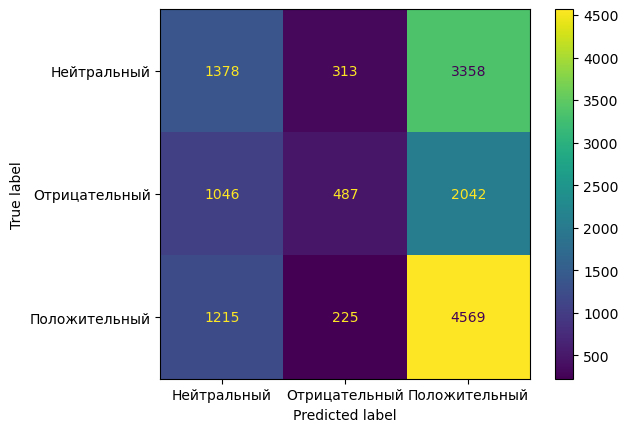

In [1513]:
params = {"n_estimators": 200,
    "max_depth": None,
    "min_samples_split": 2,
    "min_samples_leaf": 4
    }

rf_model = RandomForestClassifier(
    n_estimators=params['n_estimators'],
    max_depth=params['max_depth'],
    min_samples_split=params['min_samples_split'],
    min_samples_leaf=params['min_samples_leaf'],
    n_jobs=-1,
    random_state=42
)

rf_model .fit(X_train_vecs, y_train)

y_pred = rf_model .predict(X_test_vecs)
y_pred_proba = rf_model .predict_proba(X_test_vecs)

roc_auc = roc_auc_score(y_test, y_pred_proba, multi_class='ovr')
print(f"ROC AUC: {roc_auc}")

conf_matrix = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(conf_matrix, display_labels=label_encoder.classes_).plot()

report = classification_report(y_test, y_pred, target_names=label_encoder.classes_)
print(report)

## Бустинг для сентимент-анализа и оценка модели

In [ ]:
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

max_score = 0.5
best_params = {}

n_estimators_list = [100, 200, 500, 1000]
max_depth_list = [3, 4, 5, 6]
learning_rate_list = [0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.11, 0.12, 0.13, 0.14, 0.15]
colsample_bytree_list = [0.2, 0.5, 0.75, 1.0]

total_iterations = len(n_estimators_list) * len(max_depth_list) * len(learning_rate_list) * len(colsample_bytree_list)
progress_bar = tqdm(total=total_iterations, desc="Hyperparameter Tuning")

for n_estimators in n_estimators_list:
    for max_depth in max_depth_list:
        for learning_rate in learning_rate_list:
            for colsample_bytree in colsample_bytree_list:
                model = LGBMClassifier(
                    n_estimators=n_estimators,
                    max_depth=max_depth,
                    learning_rate=learning_rate,
                    colsample_bytree=colsample_bytree,
                    n_jobs=-1,
                    verbose=-1
                )
                model.fit(X_train_vecs, y_train)
                preds = model.predict_proba(X_test_vecs)

                score = roc_auc_score(y_test, preds, multi_class='ovr')
                if score > max_score:
                    best_params = {
                        'n_estimators': n_estimators,
                        'max_depth': max_depth,
                        'learning_rate': learning_rate,
                        'colsample_bytree': colsample_bytree
                    }
                    max_score = score

                    print(
                        f"New best score: {score} with params: "
                        f"n_estimators={n_estimators}, max_depth={max_depth}, "
                        f"learning_rate={learning_rate}, colsample_bytree={colsample_bytree}"
                    )

                progress_bar.update(1)
progress_bar.close()

print(f"Best parameters: {best_params}")
print(f"Best ROC AUC score: {max_score}")

In [1536]:
best_params = {"n_estimators": 1000,
    "max_depth": 4,
    "learning_rate": 0.09,
    "colsample_bytree": 0.2
    }

In [1538]:
best_model = LGBMClassifier(
    n_estimators=best_params['n_estimators'],
    max_depth=best_params['max_depth'],
    learning_rate=best_params['learning_rate'],
    colsample_bytree=best_params['colsample_bytree'],
    n_jobs=-1,
    verbose=-1
)
best_model.fit(X_train_vecs, y_train)

LGBMClassifier(colsample_bytree=0.2, learning_rate=0.09, max_depth=4,
               n_estimators=1000, n_jobs=-1, verbose=-1)

In [1539]:
best_preds = best_model.predict_proba(X_test_vecs)
final_score = roc_auc_score(y_test, best_preds, multi_class='ovr')
print(f"Final ROC AUC score: {final_score}")

Final ROC AUC score: 0.6535068060352105


In [1525]:
y_pred = best_model.predict(X_test_vecs)

precision_micro = precision_score(y_test, y_pred, average='micro')
recall_micro = recall_score(y_test, y_pred, average='micro')
f1_micro = f1_score(y_test, y_pred, average='micro')

precision_macro = precision_score(y_test, y_pred, average='macro')
recall_macro = recall_score(y_test, y_pred, average='macro')
f1_macro = f1_score(y_test, y_pred, average='macro')

print("Микро-усреднение:")
print(f"Precision: {precision_micro:.4f}")
print(f"Recall: {recall_micro:.4f}")
print(f"F1-Score: {f1_micro:.4f}")

print("\nМакро-усреднение:")
print(f"Precision: {precision_macro:.4f}")
print(f"Recall: {recall_macro:.4f}")
print(f"F1-Score: {f1_macro:.4f}")

print("\nОтчет по классификации:")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

Микро-усреднение:
Precision: 0.7183
Recall: 0.7183
F1-Score: 0.7183

Макро-усреднение:
Precision: 0.7286
Recall: 0.7015
F1-Score: 0.7084

Отчет по классификации:
               precision    recall  f1-score   support

  Нейтральный       0.75      0.62      0.68      5049
Отрицательный       0.74      0.63      0.68      3575
Положительный       0.69      0.85      0.76      6009

     accuracy                           0.72     14633
    macro avg       0.73      0.70      0.71     14633
 weighted avg       0.72      0.72      0.71     14633



## Ключевые слова для решения классификаторов

In [1563]:
importances = rf_model.feature_importances_
feature_names = vectorizer.get_feature_names_out()
forest_importances = pd.Series(importances, index=feature_names)
forest_importances.sort_values(ascending=False).head(20).plot(kind='bar', figsize=(10, 6), title='Feature Importances in Random Forest')
plt.show()

NameError: name 'vectorizer' is not defined